# Importing The Librarries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM
from sklearn.metrics import roc_curve, auc

# Load The Data set

In [2]:
# Load dataset
data = pd.read_csv('data.csv')

data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   int64  
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   int64  
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.2+ KB


In [4]:
data.Class.value_counts()

Class
Osmancik    2180
Cammeo      1630
Name: count, dtype: int64

In [5]:
label_enc = LabelEncoder()
data['Class'] = label_enc.fit_transform(data['Class'])

data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,0
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,0
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,0
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,0
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,0


# Spliting the features and labels

In [6]:
# Split features and labels
features = data.drop(columns=['Class'])
labels = data['Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [7]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluation of Confusion matrix

In [8]:
def calc_metrics(confusion_matrix):
    TP, FN = confusion_matrix[0][0], confusion_matrix[0][1]
    FP, TN = confusion_matrix[1][0], confusion_matrix[1][1]
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (TN + FP)
    FNR = FN / (TP + FN)
    Precision = TP / (TP + FP)
    F1_measure = 2 * TP / (2 * TP + FP + FN)
    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Error_rate = (FP + FN) / (TP + FP + FN + TN)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    metrics = [TP, TN, FP, FN, TPR, TNR, FPR, FNR, Precision, F1_measure, Accuracy, Error_rate, BACC, TSS, HSS]
    return metrics

In [9]:
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss

def get_metrics(model, X_train, X_test, y_train, y_test, LSTM_flag):    
    metrics = []
    
    if LSTM_flag == 1:
        # Convert data to numpy array
        Xtrain, Xtest, ytrain, ytest = map(np.array, [X_train, X_test, y_train, y_test])
        # Reshape data
        shape = Xtrain.shape
        Xtrain_reshaped = Xtrain.reshape(len(Xtrain), shape[1], 1)
        Xtest_reshaped = Xtest.reshape(len(Xtest), shape[1], 1)
        model.fit(Xtrain_reshaped, ytrain, epochs=50, validation_data=(Xtest_reshaped, ytest), verbose=0)
        lstm_scores = model.evaluate(Xtest_reshaped, ytest, verbose=0)
        predict_prob = model.predict(Xtest_reshaped)
        pred_labels = predict_prob > 0.5
        pred_labels_1 = pred_labels.astype(int)
        matrix = confusion_matrix(ytest, pred_labels_1, labels=[1, 0])
        lstm_brier_score = brier_score_loss(ytest, predict_prob)
        lstm_roc_auc = roc_auc_score(ytest, predict_prob)
        metrics.extend(calc_metrics(matrix))
        metrics.extend([lstm_brier_score, lstm_roc_auc, lstm_scores[1]])
        
    elif LSTM_flag == 0:
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        matrix = confusion_matrix(y_test, predicted, labels=[1, 0])
        model_brier_score = brier_score_loss(y_test, model.predict_proba(X_test)[:, 1])
        model_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        metrics.extend(calc_metrics(matrix))
        metrics.extend([model_brier_score, model_roc_auc, model.score(X_test, y_test)])
    
    return metrics


# Random Forest Classifier Model Training 

In [10]:
# Random Forest Classifier
param_grid_rf = {
"n_estimators": [10, 20, 30, 40, 50, 60, 100],
"min_samples_split": [2, 4, 6, 8, 10]
}

# Create Random Forest model
rf_classifier = RandomForestClassifier()
# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_classifier,param_grid=param_grid_rf, cv=10, n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)
# Display the best parameters from the grid search
best_rf_params = grid_search_rf.best_params_
print("\nBest Parameters for Random Forest based on GridSearchCV: ", best_rf_params)
print('\n')
# Extract the best values for 'min_samples_split' and 'n_estimators'
min_samples_split = best_rf_params['min_samples_split']
n_estimators = best_rf_params['n_estimators']


Best Parameters for Random Forest based on GridSearchCV:  {'min_samples_split': 10, 'n_estimators': 30}




# KNN Classifier Algoritm Implementation

In [11]:
#Define KNN parameters for grid search
knn_parameters = {"n_neighbors": [2, 3, 4, 6, 8, 10, 12, 15]}
# Create KNN model
knn_model = KNeighborsClassifier()
# Perform grid search with cross-validation
knn_cv = GridSearchCV(knn_model, knn_parameters, cv=10, n_jobs=-1)
knn_cv.fit(X_train_scaled, y_train)
# Print the best parameters found by GridSearchCV
print("\nBest Parameters for KNN based on GridSearchCV: ", knn_cv.best_params_)
best_n_neighbors = knn_cv.best_params_['n_neighbors']


Best Parameters for KNN based on GridSearchCV:  {'n_neighbors': 15}


# LSTM Mdel Implementation

In [12]:
from sklearn.model_selection import StratifiedKFold

# Define Stratified K-Fold cross-validator
cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)

# Initialize metric columns
metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR',
                  'Precision', 'F1_measure', 'Accuracy', 'Error_rate',
                  'BACC', 'TSS', 'HSS', 'Brier_score', 'AUC', 'Acc_by_package_fn']

# Initialize metrics lists for each algorithm
knn_metrics_list, rf_metrics_list, lstm_metrics_list = [], [], []

# 10 Iterations of 10-fold cross-validation
for iter_num, (train_index, test_index) in enumerate(cv_stratified.split(features, labels), start=1):
    # KNN Model
    knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
    # Random Forest Model
    rf_model = RandomForestClassifier(min_samples_split=min_samples_split, n_estimators=n_estimators)
    # LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(64, activation='relu', return_sequences=False))
    lstm_model.add(Dense(1, activation='sigmoid'))
    # Compile model
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    
    # Get metrics for each algorithm
    knn_metrics = get_metrics(knn_model, X_train, X_test, y_train, y_test, 0)
    rf_metrics = get_metrics(rf_model, X_train, X_test, y_train, y_test, 0)
    lstm_metrics = get_metrics(lstm_model, X_train, X_test, y_train, y_test, 1)
    
    # Append metrics to respective lists
    knn_metrics_list.append(knn_metrics)
    rf_metrics_list.append(rf_metrics)
    lstm_metrics_list.append(lstm_metrics)
    
    # Create a DataFrame for all metrics
    metrics_all_df = pd.DataFrame([knn_metrics, rf_metrics, lstm_metrics],
                                  columns=metric_columns,
                                  index=['KNN', 'RF', 'LSTM'])
    
    # Display metrics for all algorithms in each iteration
    print('\nIteration {}: \n'.format(iter_num))
    print('\n----- Metrics for all Algorithms in Iteration {} -----\n'.format(iter_num))
    print(metrics_all_df.round(decimals=2).T)
    print('\n')


24/24 [==============================] - 0s 2ms/step

Iteration 1: 


----- Metrics for all Algorithms in Iteration 1 -----

                      KNN      RF    LSTM
TP                 408.00  412.00  436.00
TN                 253.00  287.00   20.00
FP                  73.00   39.00  306.00
FN                  28.00   24.00    0.00
TPR                  0.94    0.94    1.00
TNR                  0.78    0.88    0.06
FPR                  0.22    0.12    0.94
FNR                  0.06    0.06    0.00
Precision            0.85    0.91    0.59
F1_measure           0.89    0.93    0.74
Accuracy             0.87    0.92    0.60
Error_rate           0.13    0.08    0.40
BACC                 0.86    0.91    0.53
TSS                  0.71    0.83    0.06
HSS                  0.72    0.83    0.07
Brier_score          0.10    0.06    0.36
AUC                  0.93    0.97    0.94
Acc_by_package_fn    0.87    0.92    0.60


24/24 [==============================] - 0s 2ms/step

Iteration 2: 


-----

In [13]:
# Initialize metric index for each iteration
metric_index_df = ['iter1', 'iter2', 'iter3', 'iter4', 'iter5', 'iter6', 'iter7', 'iter8', 'iter9', 'iter10']

# Create DataFrames for each algorithm's metrics
knn_metrics_df = pd.DataFrame(knn_metrics_list, columns=metric_columns, index=metric_index_df)
rf_metrics_df = pd.DataFrame(rf_metrics_list, columns=metric_columns, index=metric_index_df)
lstm_metrics_df = pd.DataFrame(lstm_metrics_list, columns=metric_columns, index=metric_index_df)
# Display metrics for each algorithm in each iteration
for i, metrics_df in enumerate([knn_metrics_df, rf_metrics_df, lstm_metrics_df], start=1):
    print('\nMetrics for Algorithm {}:\n'.format(i))
    print(metrics_df.round(decimals=2).T)
    print('\n')


Metrics for Algorithm 1:

                    iter1   iter2   iter3   iter4   iter5   iter6   iter7  \
TP                 408.00  408.00  408.00  408.00  408.00  408.00  408.00   
TN                 253.00  253.00  253.00  253.00  253.00  253.00  253.00   
FP                  73.00   73.00   73.00   73.00   73.00   73.00   73.00   
FN                  28.00   28.00   28.00   28.00   28.00   28.00   28.00   
TPR                  0.94    0.94    0.94    0.94    0.94    0.94    0.94   
TNR                  0.78    0.78    0.78    0.78    0.78    0.78    0.78   
FPR                  0.22    0.22    0.22    0.22    0.22    0.22    0.22   
FNR                  0.06    0.06    0.06    0.06    0.06    0.06    0.06   
Precision            0.85    0.85    0.85    0.85    0.85    0.85    0.85   
F1_measure           0.89    0.89    0.89    0.89    0.89    0.89    0.89   
Accuracy             0.87    0.87    0.87    0.87    0.87    0.87    0.87   
Error_rate           0.13    0.13    0.13    0.13

In [14]:
#Calculate the average metrics for each algorithm
knn_avg_df = knn_metrics_df.mean()
rf_avg_df = rf_metrics_df.mean()
lstm_avg_df = lstm_metrics_df.mean()
# Create a DataFrame with the average performance for each algorithm
avg_performance_df = pd.DataFrame({'KNN': knn_avg_df, 'RF': rf_avg_df, 'LSTM': lstm_avg_df}, index=metric_columns)
# Display the average performance for each algorithm
print(avg_performance_df.round(decimals=2))
print('\n')

                      KNN      RF    LSTM
TP                 408.00  411.50  371.20
TN                 253.00  286.30  219.20
FP                  73.00   39.70  106.80
FN                  28.00   24.50   64.80
TPR                  0.94    0.94    0.85
TNR                  0.78    0.88    0.67
FPR                  0.22    0.12    0.33
FNR                  0.06    0.06    0.15
Precision            0.85    0.91    0.81
F1_measure           0.89    0.93    0.79
Accuracy             0.87    0.92    0.77
Error_rate           0.13    0.08    0.23
BACC                 0.86    0.91    0.76
TSS                  0.71    0.82    0.52
HSS                  0.72    0.83    0.53
Brier_score          0.10    0.06    0.17
AUC                  0.93    0.97    0.93
Acc_by_package_fn    0.87    0.92    0.77




# Visualization of KNN ROC Curve

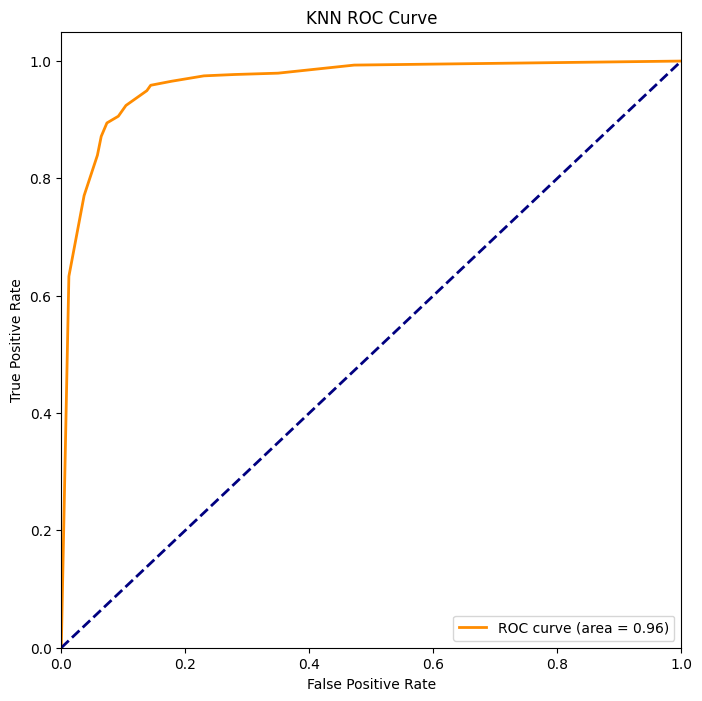

In [15]:
knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_model.fit(X_train_scaled, y_train)

# Obtain predicted probabilities
y_score = knn_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Visualization of The Random Forest ROC Curve

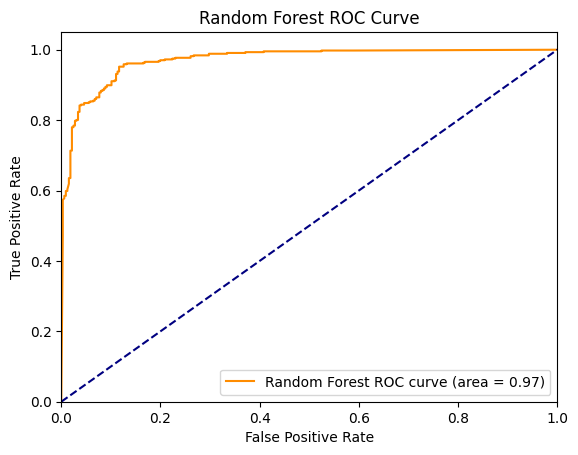

In [16]:
# Random Forest Model
rf_model = RandomForestClassifier(min_samples_split=min_samples_split, n_estimators=n_estimators)
rf_model.fit(X_train_scaled, y_train)

# Obtain predicted probabilities
y_score_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC area
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot Random Forest ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", label="Random Forest ROC curve (area = {:.2f})".format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [17]:
print(avg_performance_df.round(decimals=2))
print('\n')

                      KNN      RF    LSTM
TP                 408.00  411.50  371.20
TN                 253.00  286.30  219.20
FP                  73.00   39.70  106.80
FN                  28.00   24.50   64.80
TPR                  0.94    0.94    0.85
TNR                  0.78    0.88    0.67
FPR                  0.22    0.12    0.33
FNR                  0.06    0.06    0.15
Precision            0.85    0.91    0.81
F1_measure           0.89    0.93    0.79
Accuracy             0.87    0.92    0.77
Error_rate           0.13    0.08    0.23
BACC                 0.86    0.91    0.76
TSS                  0.71    0.82    0.52
HSS                  0.72    0.83    0.53
Brier_score          0.10    0.06    0.17
AUC                  0.93    0.97    0.93
Acc_by_package_fn    0.87    0.92    0.77


